In [1]:
import getpass
import sys
import pandas as pd

# sys.path.append('/juice/scr/katezhou/benchmarking')
# sys.path.append('/juice/scr/katezhou/benchmarking/src')
# sys.path.append('/juice/scr/katezhou/benchmarking/src/common')

from src.common.authentication import Authentication
from src.common.perspective_api_request import PerspectiveAPIRequest, PerspectiveAPIRequestResult
from src.common.request import Request, RequestResult
from src.proxy.accounts import Account
from proxy.remote_service import RemoteService

# An example of how to use the request API.
#api_key = getpass.getpass(prompt="Enter a valid API key: ")
api_key = pd.read_csv("../prod_env/api_key.csv", header=None)[0].values[0]
auth = Authentication(api_key=api_key)
service = RemoteService("https://crfm-models.stanford.edu")

# Access account and show my current quotas and usages
account: Account = service.get_account(auth)
print(account.usages)

{'gpt3': {'daily': Usage(period=None, used=0, quota=None), 'total': Usage(period=None, used=0, quota=400000)}, 'codex': {'daily': Usage(period=None, used=0, quota=0)}, 'jurassic': {'daily': Usage(period=None, used=0, quota=None), 'total': Usage(period=None, used=0, quota=0)}, 'gooseai': {'daily': Usage(period=None, used=0, quota=0)}}


In [2]:
NUM_COMPLETIONS = 100
MAX_TOKENS = 50
TEMPERATURE = 0.7
MODEL_NAME = "openai/text-davinci-001"

prompt_responses = pd.DataFrame()

prompt_example = 'tossup'
prompt_example_answer = '50%'

OUTPUT_FILE = 'uncertainty_results/' + str(MAX_TOKENS) + "_" + str(TEMPERATURE)[-1:] + "_" + MODEL_NAME[7:] + '.csv'

prompt_questions = ['almost certain', 'probable', 'likely', 'good chance', 'possible', 'tossup', 'unlikely', 'improbable', 'doubtful', 'almost impossible']

processed_words = set(list(pd.read_csv(OUTPUT_FILE, header=None)[2].values))
print("processed words", processed_words)
for prompt_question in prompt_questions:
    print(prompt_question)
    processed_words = set(list(pd.read_csv(OUTPUT_FILE, header=None)[2].values))
    if (prompt_question in processed_words):
        continue
#     request = Request(prompt="Question: What is the numerical probability of " + prompt_example 
#                       + "? Answer: " + prompt_example_answer 
#                       + ". Question: What is the numerical probability of " + prompt_question
#                       + "? Answer:", temperature=TEMPERATURE, model=MODEL_NAME, num_completions=NUM_COMPLETIONS, max_tokens=MAX_TOKENS)
#     request_result: RequestResult = service.make_request(auth, request)

#     for result in request_result.completions:
#         prompt_question_answer = result.text
#         prompt_question_logprob = result.logprob
#         print(result.text)
#         print(result.logprob)
#         print("----")
#         prompt_responses = pd.concat([prompt_responses, pd.DataFrame([[prompt_example, prompt_example_answer, prompt_question, prompt_question_answer, prompt_question_logprob]])])


#     prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)



processed words {'unlikely', 'doubtful', 'almost certain', 'almost impossible', 'probable', 'improbable', 'tossup', 'good chance', 'possible', 'likely'}
almost certain
probable
likely
good chance
possible
tossup
unlikely
improbable
doubtful
almost impossible


In [11]:
results = pd.read_csv(OUTPUT_FILE, header=None)
results.columns = ['prompt_example', 'prompt_example_response', 'prompt_question', 'prompt_question_response', 'log_prob']


In [12]:
def clean_responses(response):
    response = response.strip()
    response = response.replace("%", "")
    if (response.find(".") != -1):
        response = response[0:(response.find(".")+2)]
    #remove last period
    if (response[-1:] == '.'):
        response = response[:-1]
#     print(response)
    if (response == 'certainty'):
        response = '100'
    if (response == '1 in 10,000'):
        response = str((1/10000) * 100)
    if (response == '1 in a million'):
        response = str((1/1000000) * 100)
    if (response == '1/10,000'):
        response = str((1/10000) * 100)
    if (response == 'Less than 1 in 1,000,000'):
        response = str((1/1000000) * 100)
    if (response == '1/6'):
        response = str((1/6) * 100)
    if (response == '1/2'):
        response = str((1/2) * 100)
    if (response == '33 1/3'):
        response = '33.33'
    try:
        response = round(float(response), 0)
    except:
#         print("Not a float")
        response = float('nan')
    return response


In [13]:
results = results.groupby("prompt_question").sample(n=100).reset_index()
results

,index,prompt_example,prompt_example_response,prompt_question,prompt_question_response,log_prob
0,64,tossup,50%,almost certain,100%.,-14.048344
1,83,tossup,50%,almost certain,100%.,-8.369146
2,17,tossup,50%,almost certain,100%.,-8.364360
3,46,tossup,50%,almost certain,100%.,-12.689870
4,70,tossup,50%,almost certain,100%.,-14.482208
...,...,...,...,...,...,...
995,2123,tossup,50%,unlikely,25%.,-8.990605
996,2158,tossup,50%,unlikely,10%.,-22.125645
997,3464,tossup,50%,unlikely,10%.,-12.733183
998,3440,tossup,50%,unlikely,10%.,-12.525394


In [14]:
results['prompt_question_response'] = results['prompt_question_response'].apply(lambda x: x[:50])
results['prompt_question_response_cleaned'] = results['prompt_question_response'].apply(lambda x: clean_responses(x))


In [15]:
results = results.dropna(subset=['prompt_question_response_cleaned'])


In [16]:
results.groupby(['prompt_question'], sort=False).mean()


,index,log_prob,prompt_question_response_cleaned
prompt_question,,,
almost certain,49.500000,-10.915528,99.00
almost impossible,4549.500000,-11.202764,0.28
doubtful,4032.120000,-12.668100,22.95
good chance,2226.880000,-12.108230,43.26
improbable,3614.270000,-10.516749,6.59
likely,1573.340000,-11.234083,74.00
possible,2511.580000,-10.616373,99.17
probable,1574.970000,-11.223968,99.30
tossup,2771.958333,-10.984225,50.00


In [40]:
list(results.groupby(['prompt_question'], sort=False).mean().index)


['almost certain',
 'almost impossible',
 'doubtful',
 'good chance',
 'improbable',
 'likely',
 'possible',
 'probable',
 'tossup',
 'unlikely']

In [52]:
results.groupby(['prompt_question'], sort=False).mean().index

['almost certain',
 'almost impossible',
 'doubtful',
 'good chance',
 'improbable',
 'likely',
 'possible',
 'probable',
 'tossup',
 'unlikely']

In [56]:
grouped.mean()

,index,log_prob,prompt_question_response_cleaned
prompt_question,,,
almost certain,49.500000,-10.915528,99.00
almost impossible,4549.500000,-11.202764,0.28
doubtful,4032.120000,-12.668100,22.95
good chance,2226.880000,-12.108230,43.26
improbable,3614.270000,-10.516749,6.59
likely,1573.340000,-11.234083,74.00
possible,2511.580000,-10.616373,99.17
probable,1574.970000,-11.223968,99.30
tossup,2771.958333,-10.984225,50.00


/tmp/ipykernel_801831/983917973.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q99 = list(grouped.quantile(q=.99)['prompt_question_response_cleaned'].values)
/tmp/ipykernel_801831/983917973.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q1 = list(grouped.quantile(q=.01)['prompt_question_response_cleaned'].values)


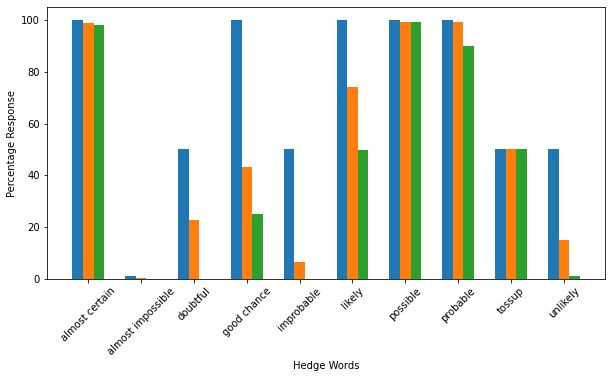

In [59]:
import numpy as np
import matplotlib.pyplot as plt

grouped = results.groupby(['prompt_question'], sort=False)
mean = list(grouped.mean()['prompt_question_response_cleaned'].values)
q99 = list(grouped.quantile(q=.99)['prompt_question_response_cleaned'].values)
q1 = list(grouped.quantile(q=.01)['prompt_question_response_cleaned'].values)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
# plt.bar(words, values, width = 0.4)

X_axis = np.arange(len(words)) * 2

plt.bar(X_axis - 0.4, q99, 0.4, label = 'Q=.99')
plt.bar(X_axis - 0.0, mean, 0.4, label = 'Mean')
plt.bar(X_axis + 0.4, q1, 0.4, label = 'Q=.01')

plt.xticks(X_axis, words)
plt.xticks(rotation = 45)
plt.xlabel("Hedge Words")
plt.ylabel("Percentage Response")
plt.show()